In [12]:
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px
from tqdm.notebook import tqdm
from itables import show
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from IPython.display import clear_output

### Read metadata, read metabolite table, read family level microbiome feature table

In [13]:
meta = pd.read_csv("input_folder/metadata48.tsv", sep="\t", index_col=0)
crit1 = meta["Group"] != "S"
crit2 = meta["Hour"] != 0

meta = meta.loc[crit1 & crit2, :]
meta["Hour"] = meta["Hour"].astype(int)
meta["GH"] = meta["Group"] + meta["Hour"].astype(str)

meta.index = [re.sub("H$", "", i) for i in meta.index]
show(meta)

In [14]:
def read_met_table(met_table_path):
    met_table = pd.read_csv(met_table_path, sep="\t", index_col=0)
    met_table.set_index("Compound", inplace=True)
    met_table = met_table.loc[:, [c for c in met_table.columns if "-" in c]]
    met_table = met_table.T
    met_table.index = [re.sub("H$", "", i) for i in met_table.index]
    return met_table

met_table_path = "input_folder/MT.tsv"

met_table = read_met_table(met_table_path)
show(met_table)

In [15]:
ft5 = pd.read_csv("input_folder/feature_table_l5.tsv", skiprows=1, sep="\t", index_col=0)
upper_bound = ft5.sum().to_list()[0]

ft5.index = [re.sub(".*p__", "p__", i) for i in ft5.index.tolist()]

ft5 = ft5.loc[ft5.sum(axis="columns").sort_values(ascending=False).index.tolist(), :]
ft5 = ft5/upper_bound*100
ft5.columns = [re.sub("H$", "", i) for i in ft5.columns.tolist()]
show(ft5)

### Mixed linear effects model
- Account for random effects within group_hour
- Assess fixed effects of hour, group, group_hour and their interaction on metabolite concentration

### Atempting mixed linear effect model, modeling how Concentration changes with Group, Hour, and their interaction, while accounting for random effects within Group-Hour samples 

In [5]:
results = []
warnings.simplefilter("ignore", ConvergenceWarning)  # optional: ignore convergence warnings

for met in tqdm(met_table.columns):
    df = meta.copy()
    df["Concentration"] = met_table[met]
    df["Group"] = df["Group"].astype("category")
    # df["Hour"] = df["Hour"].astype("category")
    df["Replicate"] = df["Replicate"].astype("category")
    
    try:
        model = mixedlm("Concentration ~ Group * Hour", data=df, groups=df["GH"])
        result = model.fit()
        pvals = result.pvalues
        results.append({
            "Metabolite": met,
            "p_Group": pvals.get("Group[T.M]", float("nan")),
            "p_Hour": pvals.get("Hour", float("nan")),  # you can handle this better later
            "p_Interaction": pvals.get("Group[T.M]:Hour", float("nan"))  # adjust for all timepoints if needed
        })

    except Exception as e:
        print(f"Failed for {met}: {e}")


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ahbui/Zarul/Software/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
/home/ahbui/Zarul/Software/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
/home/ahbui/Zarul/Software/miniconda3/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2325: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/ahbui/Zarul/Software/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ahbui/Zarul/Software/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2006: RuntimeWarning: 

In [6]:
# Assuming `results` is your list of dicts with raw p-values
results_df = pd.DataFrame(results)

# New DataFrame to hold adjusted p-values alongside raw
adjusted_df = results_df.copy()

# Adjust each p-value column and store results in new columns
for col in ["p_Group", "p_Hour", "p_Interaction"]:
    mask = results_df[col].notna()
    adjusted_pvals = [float("nan")] * len(results_df)
    if mask.sum() > 0:
        adjusted = multipletests(results_df.loc[mask, col], method='fdr_bh')[1]
        for i, idx in enumerate(results_df[mask].index):
            adjusted_pvals[idx] = adjusted[i]
    adjusted_df[f"{col}_adj"] = adjusted_pvals

# Now `adjusted_df` has:
# - Metabolite
# - p_Group, p_Hour, p_Interaction (raw)
# - p_Group_adj, p_Hour_adj, p_Interaction_adj (FDR-corrected)

In [16]:
show(adjusted_df.sort_values("p_Interaction"))

In [8]:
# define metabolite
# metabolite = "Lysinium"

def plot_metabolite_bar(change):
    # get replicate_ids
    metabolite = change["new"]
    replicates = meta.loc[:, "Replicate"].unique().tolist()
    
    metabolite_max = met_table.loc[:, metabolite].max()
    # print(metabolite_max)
    
    fig, axs = plt.subplots(ncols=len(replicates), figsize=(12,4))

    for idx, replicate in enumerate(replicates):
        ax = axs[idx]
        sub_meta = meta.loc[meta["Replicate"] == replicate, :]
        sub_meta = sub_meta.sort_values("Hour")
        sub_met_table = met_table.loc[sub_meta.index.tolist(), [metabolite]]
        

        sns.barplot(data=sub_met_table, y=sub_met_table.index, x=metabolite, ax=ax)
        ax.set_xlabel(replicate)
        
        if metabolite_max > 0:
            ax.set_xlim(0, metabolite_max)
        
        if idx == 0:
            ax.set_ylabel(metabolite)

            newticklabels = [re.sub("C.-", "", yticklabel.get_text()) for yticklabel in ax.get_yticklabels()]
            newticklabels = [re.sub("$", "H", yticklabel) for yticklabel in newticklabels]
            ax.set_yticks(ax.get_yticks())
            ax.set_yticklabels(newticklabels)
        else:
            ax.set_ylabel(None)
            ax.set_yticklabels([])
            
    fig.suptitle(metabolite)
    
    plt.tight_layout()
    plt.show()

metabolites = met_table.columns.tolist()
metabolite_dropdown = widgets.Dropdown(options=sorted(metabolites), description="Metabolites:")
# metabolite_dropdown.observe(plot_metabolite_bar, names="value")

output = widgets.Output()
dashboard = widgets.VBox([metabolite_dropdown, output])

def update_dashboard(change):
    with output:
        clear_output(wait=True)
        plot_metabolite_bar(change)

metabolite_dropdown.observe(update_dashboard, names='value')

display(dashboard)
update_dashboard({'new': metabolite_dropdown.value})

### Correlate metabolome with Paenibacillaceae

In [9]:
# Prepare your taxa vector
paeni = ft5.loc['p__Firmicutes;c__Bacilli;o__Paenibacillales;f__Paenibacillaceae', :].T
paeni.rename("Paenibacillaceae", inplace=True)

# List to collect correlation results
correlation_results = []

for met in tqdm(met_table.columns):
    smet = met_table[met]
    
    # Merge by index (samples)
    corr_df = pd.merge(paeni, smet, left_index=True, right_index=True)
    corr_df.columns = ["Paenibacillaceae", "Metabolite"]

    # Compute correlations
    try:
        r_pearson, p_pearson = pearsonr(corr_df["Paenibacillaceae"], corr_df["Metabolite"])
        r_spearman, p_spearman = spearmanr(corr_df["Paenibacillaceae"], corr_df["Metabolite"])
        
        correlation_results.append({
            "Metabolite": met,
            "r_Pearson": r_pearson,
            "p_Pearson": p_pearson,
            "r_Spearman": r_spearman,
            "p_Spearman": p_spearman
        })
        
    except Exception as e:
        print(f"Failed for {met}: {e}")

# Convert results to DataFrame
cor_df = pd.DataFrame(correlation_results)


for p_col in ["p_Pearson", "p_Spearman"]:
    mask = cor_df[p_col].notna()
    adjusted = multipletests(cor_df.loc[mask, p_col], method='fdr_bh')[1]
    cor_df.loc[mask, f"{p_col}_adj"] = adjusted

# (Optional) Filter for significant correlations
sig_corrs = cor_df[cor_df["p_Spearman_adj"] < 0.05].sort_values("p_Spearman_adj")

  0%|          | 0/388 [00:00<?, ?it/s]

/tmp/ipykernel_27618/3073473748.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_pearson, p_pearson = pearsonr(corr_df["Paenibacillaceae"], corr_df["Metabolite"])
/tmp/ipykernel_27618/3073473748.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_spearman, p_spearman = spearmanr(corr_df["Paenibacillaceae"], corr_df["Metabolite"])
/tmp/ipykernel_27618/3073473748.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_pearson, p_pearson = pearsonr(corr_df["Paenibacillaceae"], corr_df["Metabolite"])
/tmp/ipykernel_27618/3073473748.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_spearman, p_spearman = spearmanr(corr_df["Paenibacillaceae"], corr_df["Metabolite"])
/tmp/ipykernel_27618/3073473748.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient i

## Significant metabolite, sorted by p_Pearson_adj

In [17]:
show(sig_corrs.sort_values("p_Pearson_adj", ascending=False))

Dropdown(description='Metabolite:', layout=Layout(width='50%'), options=('Phenylalanylproline', 'O-acetyl-L-ca…

Dropdown(description='Metadata:', layout=Layout(width='50%'), options=('Group', 'Hour', 'GH'), value='Group')

Output()

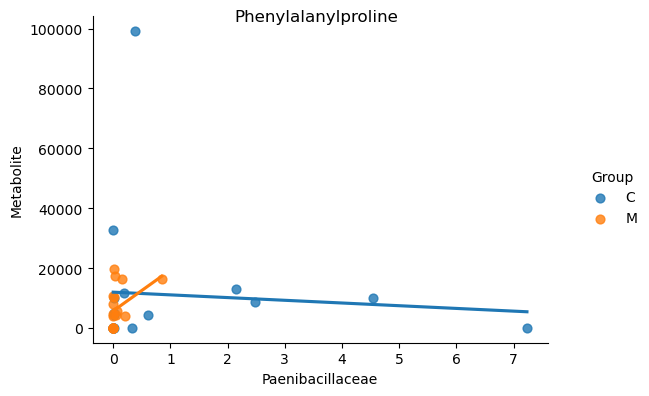

In [11]:
# Paeni series (make sure it's aligned and named properly)
paeni.name = "Paenibacillaceae"

# Dropdown options from significant metabolites
metabolite_dropdown = widgets.Dropdown(
    options=sig_corrs.sort_values("p_Pearson_adj", ascending=False)["Metabolite"].tolist(),
    description='Metabolite:',
    layout=widgets.Layout(width='50%')
)

metadata_dropdown = widgets.Dropdown(
    options=["Group", "Hour", "GH"],
    description='Metadata:',
    layout=widgets.Layout(width='50%')
)

# Output widget for plot
out = widgets.Output()

# Plotting function
def plot_corr(change):
    metabolite_name = metabolite_dropdown.value
    metadata_name = metadata_dropdown.value
    smet = met_table[metabolite_name]
    
    # Merge
    corr_df = pd.merge(paeni, smet, left_index=True, right_index=True)
    corr_df.columns = ["Paenibacillaceae", "Metabolite"]
    corr_df = pd.merge(corr_df, meta, left_index=True, right_index=True)

    # Plot
    with out:
        clear_output(wait=True)
        
        g = sns.lmplot(
            data=corr_df,
            x="Paenibacillaceae",
            y="Metabolite",
            hue=metadata_name,
            scatter_kws={"s": 40, "alpha": 0.8},
            height=4, aspect=1.5, ci=0,
            legend_out=True,
        )

        # Adjust space for the legend on the right
        g.fig.subplots_adjust(right=0.85)
        g.fig.suptitle(metabolite_name)

# Attach handler
metabolite_dropdown.observe(plot_corr, names='value')
metadata_dropdown.observe(plot_corr, names='value')

# Initial call
plot_corr(None)

# Display dashboard
display(metabolite_dropdown, metadata_dropdown, out)